In [1]:
import numpy as np
from numpy import genfromtxt
from collections import Counter
from sklearn.cluster import KMeans
import pandas
import random
import math
from sklearn import svm
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

## Loading in Data:

In [2]:
reviews = genfromtxt('review_matrix.csv', delimiter=',') # reviewer by movie (2482x818)
movies = pandas.read_csv('movie_data_cleaned_v2.csv') # all movies (3801 by 56)
review_to_movie = genfromtxt('review_to_imdb.csv', delimiter=',') # col in reviews -> row in movies
reviewer_to_gender = genfromtxt('review_to_gender.csv', delimiter=',')
reviewer_to_gender = map(lambda x: "m" if x==0 else "f", reviewer_to_gender) # row in reviews -> gender

In [3]:
num_reviewers = np.shape(reviews)[0]
num_movies = np.shape(reviews)[1]

## Minor Pre-Processing

There are a lot of reviewers that do not review many movies. Here, we set a minimum number of movies for a reviewer to be used in our classification. This number may change in later approaches where we combine review data from similar reviewers in the training set. 

In [4]:
min_num_reviews = 100 # do not include reviewers with < min_num_reviews reviews total
count_reviews = np.sum(np.absolute(reviews),axis=1)
good_reviewers = filter(lambda x: count_reviews[x] >= min_num_reviews, range(num_reviewers))
print("This leads to %d good reviewers." % np.shape(good_reviewers)[0])

### Use data structures below to make life easier ###
num_good_reviewers = len(good_reviewers)
good_reviews = reviews[good_reviewers,:]
good_reviewer_to_gender = [reviewer_to_gender[x] for x in good_reviewers]

This leads to 92 good reviewers.


In [5]:
good_movies = []
index = 0
for i in review_to_movie:
    good_movies.append(movies[int(i):int(i+1)].to_dict())
    for key in good_movies[index]:
        good_movies[index][key] = good_movies[index][key][i]
    index+=1
good_movies = pandas.DataFrame(good_movies)

Here are all the important variables moving forward:
* num_good_reviewers, num_movies (specify dimensions of good_reviews matrix)
* good_reviews: reviewer by movie matrix (+1 is positive review, -1 is negative, 0 is no review)
* good_movies: movies that we have reviews for (cols here correspond to rows in good_reviews)
* good_reviewer_to_gender: reviewer idx to gender map

## Generally Useful Functions

In [6]:
### Returns something of the form [x,...,x] where x can be any object
def list_of_x(x, length):
    lst = np.empty((length,), dtype=np.object_)
    lst.fill(x)
    return np.frompyfunc(list,1,1)(lst)

def mean_matrix(v, n):
    v = np.matrix(v)
    mean = v.mean(axis=0)
    return np.repeat(mean,n,axis=0)

## Get Test/ Training Split

For now, lets do a 50/50 split. This ends up with a data-structure such that train[i] represents the columns (movies) in reviews that correspond to the testing set. The 50/50 split is done such that for each reviewer, half of their reviews are training and half are test. 

In [7]:
### Returns tuple with training and testing indices
### train: list of length num_good_reviewers
### train[i]: list of movie indices that are in training set for reviewer i
### Similar format for test
### Arguments: split - percentage of data going to train
def get_train_test(split):  
    train = list_of_x([],num_good_reviewers)
    test = list_of_x([],num_good_reviewers)
    for i in range(num_good_reviewers):
        valid_ind = filter(lambda x: not good_reviews[i][x] == 0, range(num_movies))
        train[i] = [valid_ind[j] for j in sorted(random.sample(xrange(len(valid_ind)), int(len(valid_ind)*split)))]
        test[i] = filter(lambda x: x not in train[i] and x in valid_ind, range(num_movies))
    return (train,test)
(train,test) = get_train_test(0.5)

## Functions to Deal with Movie Data

## Useful Testing Functions

In [8]:
def get_confusion_matrix(pred, test):
    m = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    for i in range(num_good_reviewers):
        for j in range(len(pred[i])):
            prediction = pred[i][j]
            actual = good_reviews[i][test[i][j]]
            if (prediction == actual):
                if (prediction == 1):
                    m["tp"]+=1
                else:
                    m["tn"]+=1
            else:
                if (prediction == 1):
                    m["fp"]+=1
                else:
                    m["fn"]+=1
    return m

In [9]:
def get_error(pred, test):
    conf_m = get_confusion_matrix(pred,test)
    return 1-(conf_m["tp"]+conf_m["tn"])/float(conf_m["tp"]+conf_m["tn"]+conf_m["fp"]+conf_m["fn"])

In [10]:
def summarize_conf_m(pred,test):
    conf_m = get_confusion_matrix(pred,test)
    print("True Positive Rate: %0.2f" % (conf_m["tp"]/float(conf_m["tp"]+conf_m["fn"])))
    print("True Negative Rate: %0.2f" % (conf_m["tn"]/float(conf_m["tn"]+conf_m["fp"])))

## Baseline Approach

* Set all testing to label of most common training label (does not use movies)

In [11]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    if (Counter(good_reviews[i][train[i]]).most_common(1)[0][0] == -1):
        pred[i] = -1*pred[i]
print(get_confusion_matrix(pred,test))
print("Error: %0.4f" % get_error(pred,test))
summarize_conf_m(pred,test)

{'tn': 996, 'fp': 2892, 'fn': 852, 'tp': 4638}
Error: 0.3992
True Positive Rate: 0.84
True Negative Rate: 0.26


## Cluster Movies, Group Based on Most Common Label of Movies in that Cluster

### Use full set of features

In [12]:
rel_features = ["num_critic_for_reviews", "duration", "director_facebook_likes", 
                "actor_1_facebook_likes", "budget", "gross" , "cast_total_facebook_likes",
               "action", "adventure", "fantasy", "sci_fi", "thriller", "romance",
               "animation", "comedy", "family", "musical", "mystery", "western",
               "drama", "history", "sport", "crime", "horror", "war", "biography",
               "music", "documentary", "film_noir","pg_13","pg","g","r","approved",
               "nc_17","not_rated","x","unrated","m","gp","passed"]
X = np.zeros((num_movies, len(rel_features)))
for i in range(num_movies):
    for j in range(len(rel_features)):
        X[i,j] = good_movies.iloc[i][rel_features[j]]

In [13]:
# standardize X
X_norm = (X - np.mean(X)) / np.std(X)

Perform 10-fold cross validation to find the best number of clusters

In [14]:
cluster_size = range(2,21)
cv_error = np.zeros(len(cluster_size))

k_fold = KFold(n_splits=10)
for k in cluster_size:
    error = np.array([KMeans(n_clusters=k,random_state=0).fit(X_norm[train_set]).inertia_
                      for train_set, test_set in k_fold.split(X_norm)])
    cv_error[cluster_size.index(k)] = np.mean(error)

Plot to find best number of clusters

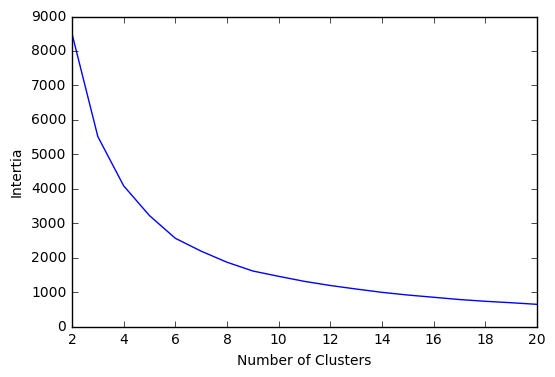

In [15]:
plt.plot(cluster_size,cv_error)
plt.ylabel('Intertia')
plt.xlabel('Number of Clusters')
plt.show()

Elbow present at 6, so we choose 6 clusters

In [16]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_norm)
movie_labels = kmeans.labels_

Now we test

In [17]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    k_labels = np.zeros(k)
    for j in range(num_movies):
        if (j in train[i]):
            k_labels[movie_labels[j]]+=good_reviews[i][j]
    for j in range(len(test[i])):
        if (k_labels[movie_labels[test[i][j]]] > 0):
            pred[i][j]=1
        else:
            pred[i][j]=-1
print(get_confusion_matrix(pred,test))
print("Error: %0.4f" % get_error(pred,test))
summarize_conf_m(pred,test)

{'tn': 1669, 'fp': 2219, 'fn': 1608, 'tp': 3882}
Error: 0.4081
True Positive Rate: 0.71
True Negative Rate: 0.43


## How About SVM

In [18]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    # train SVM
    X_train = X[train[i],:]
    Y_train = good_reviews[i][train[i]]
    clf = svm.SVC(random_state=0)
    clf.fit(X_train, Y_train)
    pred[i] = clf.predict(X[test[i],:])
print(get_confusion_matrix(pred,test))
print("Error: %0.4f" % get_error(pred,test))
summarize_conf_m(pred,test)

{'tn': 996, 'fp': 2892, 'fn': 852, 'tp': 4638}
Error: 0.3992
True Positive Rate: 0.84
True Negative Rate: 0.26


## Trees

### Decision Tree

In [26]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    X_train = X[train[i],:]
    Y_train = good_reviews[i][train[i]]
    clf = tree.DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, Y_train)
    pred[i] = clf.predict(X[test[i],:])
print(get_confusion_matrix(pred,test))
print("Error: %0.4f" % get_error(pred,test))
summarize_conf_m(pred,test)

{'tn': 1841, 'fp': 2047, 'fn': 2066, 'tp': 3424}
Error: 0.4386
True Positive Rate: 0.62
True Negative Rate: 0.47


### Random Forest

In [28]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    X_train = X[train[i],:]
    Y_train = good_reviews[i][train[i]]
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X_train, Y_train)
    pred[i] = rf.predict(X[test[i],:])
print(get_confusion_matrix(pred,test))
print("Error: %0.4f" % get_error(pred,test))
summarize_conf_m(pred,test)

{'tn': 2139, 'fp': 1749, 'fn': 2037, 'tp': 3453}
Error: 0.4037
True Positive Rate: 0.63
True Negative Rate: 0.55


## Try Above but with PCA on X

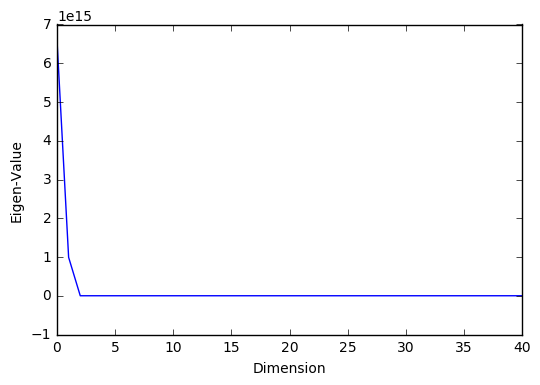

In [19]:
sigma = np.cov(np.matrix(X).T)
e = np.linalg.eigh(sigma)
e_vals_i = e[0]
e_vecs_i = e[1]
idx = e_vals_i.argsort()[::-1]   
e_vals = e_vals_i[idx]
e_vecs = e_vecs_i[:,idx]
plt.plot(e_vals)
plt.xlabel("Dimension")
plt.ylabel("Eigen-Value")
w = e_vecs[:,0:4]
pca = PCA(n_components=4)
pca.fit(X)
pca_X = pca.transform(X)
pca_X = (np.matrix(X)-mean_matrix(X,num_movies)) * np.matrix(w)

### Clustering

In [21]:
cv_error = np.zeros(len(cluster_size))

for k in cluster_size:
    error = np.array([KMeans(n_clusters=k,random_state=0).fit(pca_X[train_set]).inertia_
                      for train_set, test_set in k_fold.split(pca_X)])
    cv_error[cluster_size.index(k)] = np.mean(error)

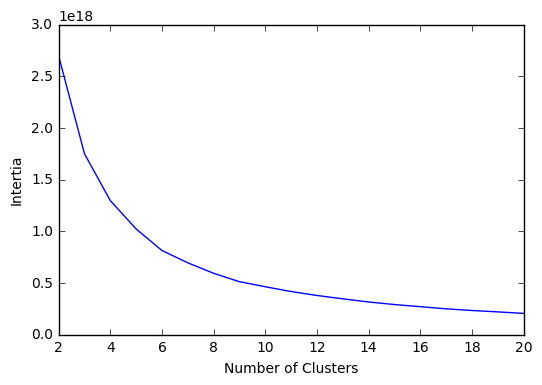

In [22]:
plt.plot(cluster_size,cv_error)
plt.ylabel('Intertia')
plt.xlabel('Number of Clusters')
plt.show()

In [23]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=0).fit(pca_X)
movie_labels = kmeans.labels_

In [24]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    k_labels = np.zeros(k)
    for j in range(num_movies):
        if (j in train[i]):
            k_labels[movie_labels[j]]+=good_reviews[i][j]
    for j in range(len(test[i])):
        if (k_labels[movie_labels[test[i][j]]] > 0):
            pred[i][j]=1
        else:
            pred[i][j]=-1
print(get_confusion_matrix(pred,test))
print("Error: %0.4f" % get_error(pred,test))
summarize_conf_m(pred,test)

{'tn': 1672, 'fp': 2216, 'fn': 1608, 'tp': 3882}
Error: 0.4078
True Positive Rate: 0.71
True Negative Rate: 0.43


### SVM

In [20]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    # train SVM
    X_train = pca_X[train[i],:]
    Y_train = good_reviews[i][train[i]]
    clf = svm.SVC(random_state=0)
    clf.fit(X_train, Y_train)
    pred[i] = clf.predict(pca_X[test[i],:])
print(get_confusion_matrix(pred,test))
print("Error: %0.4f" % get_error(pred,test))
summarize_conf_m(pred,test)

{'tn': 996, 'fp': 2892, 'fn': 852, 'tp': 4638}
Error: 0.3992
True Positive Rate: 0.84
True Negative Rate: 0.26


### Decision Tree

In [29]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    X_train = pca_X[train[i],:]
    Y_train = good_reviews[i][train[i]]
    clf = tree.DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, Y_train)
    pred[i] = clf.predict(pca_X[test[i],:])
print(get_confusion_matrix(pred,test))
print("Error: %0.4f" % get_error(pred,test))
summarize_conf_m(pred,test)

{'tn': 1826, 'fp': 2062, 'fn': 2139, 'tp': 3351}
Error: 0.4480
True Positive Rate: 0.61
True Negative Rate: 0.47


### Random Forest

In [30]:
pred = list_of_x([],num_good_reviewers)
for i in range(num_good_reviewers):
    pred[i] = np.ones(len(test[i]))
    X_train = pca_X[train[i],:]
    Y_train = good_reviews[i][train[i]]
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X_train, Y_train)
    pred[i] = rf.predict(pca_X[test[i],:])
print(get_confusion_matrix(pred,test))
print("Error: %0.4f" % get_error(pred,test))
summarize_conf_m(pred,test)

{'tn': 1978, 'fp': 1910, 'fn': 2155, 'tp': 3335}
Error: 0.4335
True Positive Rate: 0.61
True Negative Rate: 0.51
